# Exploratory Data Analysis (EDA)

This notebook performs a very rudimentary EDA on the original CFPB dataset. The objectives of this notebook are to:
1. Introduce the dependent and independent variables that will be used in the modeling approach.
    - The independent variables will be mixed to showcase how this can be modeling using a custom PyTorch Module. The independent variables will consist of: A) unstructured text field and B) some categorical fields.
2. Remove any nulls values from the dataset for future modeling tasks.
    - This preprocessed dataset will be saved back to disk for use in modeling.
3. Save a very reduced dataset which will be used for the debugging feature in pipeline development.
    - This is a trick that can be used to tremendously speed up pipeline/code development.
4. Save about 15% of data to disk for experimenting/working with because the full ~386K dataset takes a long to process.

In [1]:
# Import Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader

# Allow HF tokenizer parallelism
os.environ['TOKENIZERS_PARALLELISM'] = 'True'

# User Inputs

In [2]:
# Path to Data
PATHS = {'data': '../data/rows.csv',
         'hf_cache': os.environ['TRANSFORMERS_CACHE'],
         'save_processed_data': '../data/cfpb.csv',
         'save_debug_data': '../data/cfpb_debug.csv',
         'save_partial_data': '../data/cfpb_partial.csv'}

# Name of the model
model_name = 'bert-base-uncased'

# Load Data and Basic EDA

The basic EDA will be to view the number of unique values, remove nulls, and select a few different source fields that could be used to predicting the target variable.

In [3]:
# Load Data
df = pd.read_csv(PATHS['data'], low_memory=False)

# Display data shape and some rows
print(f'CFPB Data Shape: ({df.shape[0]:,}, {df.shape[1]})')
display(df.head(2))

CFPB Data Shape: (1,282,355, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,05/10/2019,Checking or savings account,Checking account,Managing an account,Problem using a debit or ATM card,NaN,NaN,NAVY FEDERAL CREDIT UNION,FL,328XX,Older American,NaN,Web,05/10/2019,In progress,Yes,NaN,3238275
1,05/10/2019,Checking or savings account,Other banking product or service,Managing an account,Deposits and withdrawals,NaN,NaN,BOEING EMPLOYEES CREDIT UNION,WA,98204,NaN,NaN,Referral,05/10/2019,Closed with explanation,Yes,NaN,3238228


In [4]:
# Uniques for each field
tmp = df.describe(include='all').loc['unique', :]
display(tmp.to_frame().style.format("{:,.0f}"))
del tmp

,unique
Date received,"2,717"
Product,18
Sub-product,76
Issue,167
Sub-issue,218
Consumer complaint narrative,"366,945"
Company public response,10
Company,"5,275"
State,63
ZIP code,"22,591"


In [5]:
# Number of nulls in source fields
source_fields = ['Consumer complaint narrative',
                 'ZIP code',
                 'Sub-issue']
target = 'Product'
print(f'Number of Non-Nulls in Each Column BEFORE Removing Nulls')
n_rows = len(df)
for col in source_fields:
    print(f'\t{col}: {n_rows - df[col].isnull().sum():,}')

# Reduce the dataframe to only non-null consumer complaints
data = (df.dropna(subset=source_fields)
        .reset_index(drop=True))
print((f'CFPB Data Shape After Removing Nulls:'
       f'({data.shape[0]:,}, {data.shape[1]})'))

# Number of nulls in source fields AFTER removing Nulls
print(f'Number of Non-Nulls in Each Column AFTER Removing Nulls')
n_rows = len(data)
for col in source_fields:
    print(f'\t{col}: {n_rows - data[col].isnull().sum():,}')

Number of Non-Nulls in Each Column BEFORE Removing Nulls
	Consumer complaint narrative: 383,564
	ZIP code: 1,167,057
	Sub-issue: 751,169
CFPB Data Shape After Removing Nulls:(209,586, 18)
Number of Non-Nulls in Each Column AFTER Removing Nulls
	Consumer complaint narrative: 209,586
	ZIP code: 209,586
	Sub-issue: 209,586


In [6]:
# Value counts for the target 'Product'
for col in [target]:
    print(col)
    tmp = data[col].value_counts().to_frame().style.format("{:,.0f}")
    display(tmp)
    del tmp

Product


,count
Product,
"Credit reporting, credit repair services, or other personal consumer reports","71,813"
Debt collection,"66,702"
Credit reporting,"24,524"
Credit card or prepaid card,"15,992"
Student loan,"15,846"
Checking or savings account,"10,130"
Vehicle loan or lease,"4,387"
"Payday loan, title loan, or personal loan",192


In [7]:
# https://esource.dbs.ie/bitstream/handle/10788/4224/msc_shivaprasad_vm_2020.pdf?sequence=1&isAllowed=y
# Reduce the "Product" categories for quicker processing
keep_products = ['Debt collection',
                 'Credit reporting',
                 'Credit card or prepaid card',
                 'Student loan',
                 'Vehicle loan or lease',
                 ]
data = data[data['Product'].isin(keep_products)].reset_index(drop=True)
print(f'CFPB Data Shape: ({data.shape[0]:,}, {data.shape[1]})')
display(data['Product'].value_counts())

CFPB Data Shape: (127,451, 18)


Product
Debt collection                66702
Credit reporting               24524
Credit card or prepaid card    15992
Student loan                   15846
Vehicle loan or lease           4387
Name: count, dtype: int64

# Number of Tokens Distribution

The field `Consumer complaint narrative` is the unstructured text source field that will be used to predict the target variable. The `bert-base-uncased` model used in this example only allows for a maximum of 512 tokens. Text past this point will be truncated. There are other methods (e.g., sliding windows) that can handle longer text but will not be implemented in this repository. Therefore, we can check the distribution of the number tokens for this field. 

In [8]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(f'{PATHS["hf_cache"]}/'
                                          f'{model_name}')

# View the Model configuration JSON
os.system(f'cat {PATHS["hf_cache"]}/{model_name}/config.json')

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}


0

In the above cell the `max_position_embeddings=512` parameter for the BERT model means BERT can only take input sequences up to 512 tokens in length. There are solutions for handling longer text as discussed in this article by [Salt Data Labs](https://www.saltdatalabs.com/blog/bert-how-to-handle-long-documents#:~:text=However%2C%20BERT%20can%20only%20take,much%20longer%20than%20512%20words.).

A few observations about the below cell:
- To speedup calculations the Torch Dataset and DataLoader modules will be used which allows for multi-core processing using parameter `num_workers`. This provides over an ~8X speed up on my computer versus using a simple pandas.apply() function call (i.e., single core use).
- Notice how the Torch Dataset and DataLoader modules can be modified to create custom solutions; like in the example below they are being used to count the number of tokens in the field `Consumer complaint narrative`.

Number of token distribution:


count    127451.000000
mean        223.945312
std         249.286584
min           4.000000
25%          81.000000
50%         152.000000
75%         281.000000
max        8756.000000
Name: num_tokens, dtype: float64

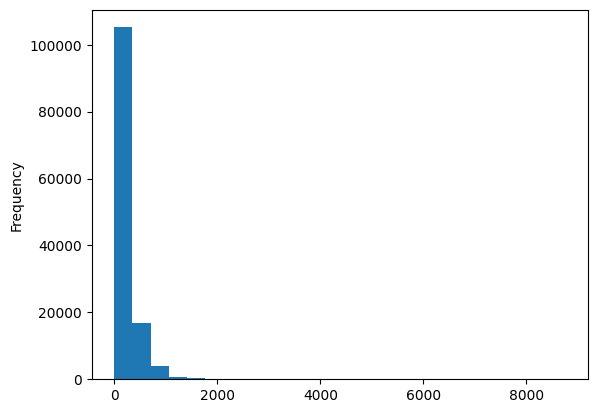

In [9]:
class CountTokens(Dataset):
    def __init__(self, texts, tok):
        self.texts = texts
        self.tok = tok
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        # Number of tokens in string
        values = self.tok.encode_plus(text=self.texts[item],
                                      padding=False,
                                      truncation=False)
        return len(values['input_ids'])

# Temporary Dataframe
tmp = data[source_fields[0]].copy().to_frame()

# Datasets and dataloaders
tokens_dataset = CountTokens(texts=tmp[source_fields[0]].values,
                             tok=tokenizer)
tokens_dataloader = DataLoader(tokens_dataset,
                               batch_size=1_024,
                               shuffle=False,
                               num_workers=8)

# Count number of tokens in dataframe
num_tokens = []
for count, token_lengths in enumerate(tokens_dataloader):
    num_tokens.extend(token_lengths.numpy().tolist())
tmp['num_tokens'] = num_tokens
print('Number of token distribution:')
display(tmp.num_tokens.describe())
tmp.num_tokens.plot(kind='hist', bins=25)
plt.show()
del tmp

# Save Data to Disk

The preprocessed data will be saved to disk for modeling.

### Dataset 1 of 3: All Data

This is all the training data and is recommended when final model training is ready/needed. This will result in longer run time.

In [10]:
# Reduce the data to only the necessary columns
data = data[source_fields + [target]]

# Save preprocessed data
data.to_csv(PATHS['save_processed_data'], index=False)
print(f'CFPB Data Shape: ({data.shape[0]:,}, {data.shape[1]})')
print(data.columns)

CFPB Data Shape: (127,451, 4)
Index(['Consumer complaint narrative', 'ZIP code', 'Sub-issue', 'Product'], dtype='object')


### Dataset 2 of 3: Debug Data

This is a very small sample of data and is ideal for using in code development. With the data being so small it will allows for quick load times and processing so minimal time is wasted waiting for preprocessing / data loading.

In [11]:
# Downsample data to a much smaller size
# This data will be quicker for all operations when debugging code
prod_uniques = data.Product.unique()

# Sample 5 instances for each value in Product
# Product has 18 unique values; therefore 5 * 5 = 25 instances
data_debug = None
for prod_value in prod_uniques:
    tmp = data[data.Product == prod_value].iloc[0:5, :]
    if data_debug is None:
        data_debug = tmp
    else:
        data_debug = pd.concat([data_debug, tmp],
                               ignore_index=True)
# Shuffle the rows
data_debug = data_debug.sample(frac=1)
print(f'Num. of Instances in Debug Data: {len(data_debug):,}')

data_debug.to_csv(PATHS['save_debug_data'], index=False)

Num. of Instances in Debug Data: 25


### Dataset 3 of 3: Partial Data

This dataset will be used for experimenting/demos because it takes a long time to process the full Dataset #1.

In [12]:
# Downsample data to a much smaller size
# This data will be quicker for all operations when debugging code
prod_uniques = data.Product.unique()
N = 2_000
# Sample N instances for each value in Product
# Product has 5 unique values; therefore 1,000 * 5 = 5,000 instances
data_partial = None
for prod_value in prod_uniques:
    tmp = data[data.Product == prod_value].iloc[0:N, :]
    if data_partial is None:
        data_partial = tmp
    else:
        data_partial = pd.concat([data_partial, tmp],
                                 ignore_index=True)
# Shuffle the rows
data_partial = data_partial.sample(frac=1)
print(f'Num. of Instances in Partial Data: {len(data_partial):,}')

data_partial.to_csv(PATHS['save_partial_data'], index=False)

Num. of Instances in Partial Data: 10,000


# Summary

- **DATA**:
    - Number of Independent variables = 3
        - `Consumer complaint narrative`: string of unstructured text and all instances are unique 
        - `Zip Code`: a categorical variable with high cardinality (i.e., > 20K unique values)
        - `Sub-issues`: a categorical variable with 63 unique values
    - Dependent Variable = `Product`
        - `Product`: categorical with 5 unique values
    - Two datasets were created for modeling:
        - `Primary` dataset has ~127K instances
        - `Debug` dataset with 25 instances which is help when developing code
        - `Partial` dataset with 10K instances for faster processing
- **NOTES**: 
    - No emphasis was placed on selecting optimal independent variables for modeling because the focus of this repository is to highlight a workflow. Mixed data types (i.e., text and categorical variables) were selected to demonstrate their usage during modeling.

### Next Steps:

Refer to the [training.ipynb](./training.ipynb) Jupyter Notebook that demonstrates how to fine-tune a multi-classification LLM model, using a generic PyTorch workflow, on this data.
